TODOs:

1) Rearange data Train/Val/Test
2) Check how well data is balanced
2) implement Recall or F2 Score

# Introduction

This is the final project for the programme in Machine Learning & Artificial Intelligence. For this project the chosen dataset was obtained from Kaggle. The dataset comprehends x-ray images from * *, and the goal is to train a classifier that is able to diagnose patients for pneumonia. 

The dataset... The format of the data(images),  Is the data clean?, How large is the dataset?  The split into train/val/test.


The method CNN...


The optimization of the model... bayesian importance, etc

The steps taken to treat the model...

The metrics chosen - accuracy...




1. Code presentation: Other people should be able to implement your code easily. Make sure it is well commented and clear. It is recommended that you use a Jupyter Notebook to present your method and results.  
  
2. Datasheet and model card: As you learned in Module 20, it is really important you, and others using your model, understand the limitations and biases in the data and in the model itself. You should fill out the datasheet and model card templates and include these in your projects. See the example Google model cards for inspiration.  
  
3. Non-technical write-up: When doing machine learning, it is important to be able to explain the process and results to a non-technical audience. A good explanation can increase trust in a model and can help influence decisions on whether to use the model. In your README file, you should include a 100-word description of what your model is doing, outlining your results to a general audience.



# Imports

In [6]:
import cv2  # !pip install opencv-python

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision
import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import splitfolders

import torch.nn as nn  # model
import torch.nn.functional as F  # model

import torch.optim as optim  # optimizer
import time  # so we can keep track of time...


from torchinfo import summary  # exp.track
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import pickle as pkl

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import normalize,MinMaxScaler,StandardScaler
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

import itertools as it
import shutil


In [7]:
# Setting Seeds
# we will do in helper functions

# Helper Functions

- The function img_loader() is used by the Imagefolder function to read the data images from a specific folder. 
- imshow() just displays any requested image

In [8]:
# img = cv2.imread("some_image.pgm", cv2.IMREAD_COLOR)

def img_loader(filename):
    
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    width = 224  #200
    height = 224  #200
    dim = (width,height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

def save_ckp(state, is_best, checkpoint_dir, best_model_dir):
    f_path = f'{checkpoint_dir}/checkpoint.pt'
    torch.save(state, f_path)
    if is_best:  # if saving best model separate
        best_fpath = f'{best_model_dir}/best_model.pt'
        shutil.copyfile(f_path, best_fpath)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

- accu_check_overall(...)  is used for calculating accuracy metric

In [9]:
def count_classes(loader):
    class_list = torch.Tensor()
    for data in loader:
        _, labels = data
        class_list = torch.cat((class_list, labels))
    return class_list


def perf_check_overall(net_model, test_df):
    correct = 0
    total = 0
    
    prediction_list = torch.Tensor()
    label_list = torch.Tensor()
    
    with torch.no_grad():
        for data in test_df:
            images, labels = data
            outputs = net_model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            prediction_list = torch.cat((prediction_list,predicted))
            label_list = torch.cat((label_list,labels))
                                       
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = correct / total
    recall = recall_score(label_list, prediction_list)
    f2score = fbeta_score(label_list, prediction_list, beta=2)
    print(f'Recall -> {recall}')
    print(f'Accuracy -> {accuracy}')
    print(f'f2 score -> {f2score}')
    print('Accuracy of the network w/ validation/test: %d %%' % (
        100 * accuracy))
    return accuracy, recall, f2score

In [10]:
def recall_check_overall(net_model, test_df):
    #recall_score()
    pass

- The function set_seeds is used for preventing getting different results due to random values each time the model runs.

In [11]:
def set_seeds(seed: int=42):
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

# Data

## Dataset partitioning

The data obtained was already partioned in training, validation and test. However it was found to be unsuitable, so the data has been re-unified to be split again. Using splitfolders 70% of the data been assigned to train, 15% validation and the remaining 15% for testing.

In [18]:
run_split_folders = True

if run_split_folders:
    splitfolders.ratio("./data/raw/chest_xray_full/data", 
                       output="./data/partitioned_data", 
                       seed=1337, 
                       ratio=(.7, .15, .15), 
                       group_prefix=None, 
                       move=False)

# Copying files: 5856 files [01:44, 55.89 files/s] 

Copying files: 5856 files [00:04, 1383.11 files/s]


## Loading data with DataLoader

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

- By using a DataLoader we prevent running out of memory

In [19]:
data_train = ImageFolder(root='./data/partitioned_data/train/', loader=img_loader,
                         transform=transform)

data_val = ImageFolder(root='./data/partitioned_data/val/', loader=img_loader,
                       transform=transform)

data_test = ImageFolder(root='./data/partitioned_data/test/', loader=img_loader,
                        transform=transform)

trainloader = torch.utils.data.DataLoader(data_train, batch_size=4, 
                                          shuffle=True, num_workers=0)

valloader = torch.utils.data.DataLoader(data_val, batch_size=4, 
                                        shuffle=False, num_workers=0)

testloader = torch.utils.data.DataLoader(data_test, batch_size=4,
                                         shuffle=False, num_workers=0)

In [21]:
def count_classes(loader):
    class_list = torch.Tensor()
    for data in loader:
        _, labels = data
        class_list = torch.cat((class_list, labels))
    return class_list

if run_split_folders:
    train_labels = count_classes(trainloader)
    val_labels   = count_classes(valloader)
    test_labels  = count_classes(testloader)
    
    df_count_samples = pd.DataFrame(index=['Training', 'Validation','Test'])
    df_count_samples['Total Size'] =[len(train_labels), len(val_labels), len(test_labels)]
    df_count_samples['Class 0'] = [int(len(train_labels)-train_labels.sum()),int(len(val_labels)-val_labels.sum()),int(len(test_labels)-test_labels.sum())]
    df_count_samples['Class 1'] = df_count_samples['Total Size'] - df_count_samples['Class 0']
    df_count_samples.to_pickle('./workflow_data/df_count_samples.pkl')
else:
    df_count_samples = pd.read_pickle('./workflow_data/df_count_samples.pkl')
    
#1m40s

In [22]:
df_count_samples

,Total Size,Class 0,Class 1
Training,4099,1108,2991
Validation,877,237,640
Test,880,238,642


In [23]:
data_train.class_to_idx

{'NORMAL': 0, 'PNEUMONIA': 1}

- As we can see data is not balanced, the dominand class is "Class 1" - Pneumonia.

In [24]:
classes_t = data_train.classes

In [25]:
dataiter = iter(trainloader)

In [26]:
images, labels = next(dataiter)

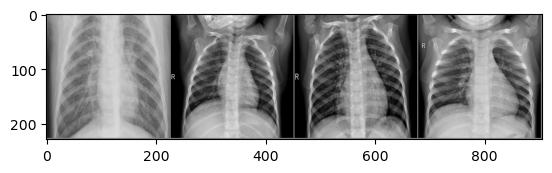

PNEUMONIA NORMAL PNEUMONIA NORMAL


In [27]:
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes_t[labels[j]] for j in range(4)))

# The model

## The standard model

The diagrams below illustrate the architecture of a classical LeNet-5 Network.


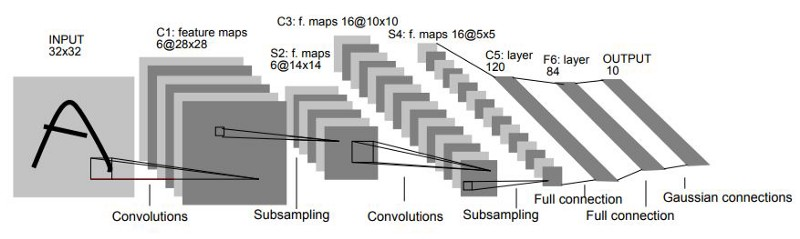

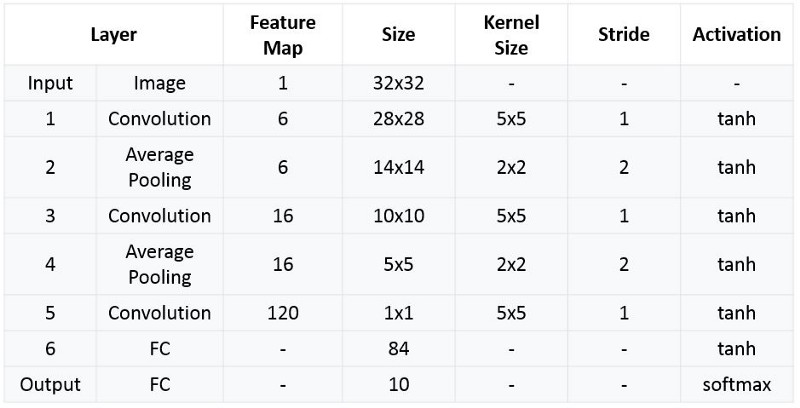

*Source: https://www.datasciencecentral.com*

LeNet-5 is a convolutional neural network (CNN) architecture developed by Yann LeCun in 1998 for handwritten digit recognition. It consists of seven layers, including two convolutional layers, two pooling layers, and two fully connected layers. The first convolutional layer extracts features using a 5x5 filter, followed by a pooling layer. The second convolutional layer extracts more complex features using a 5x5 filter, followed by another pooling layer. The extracted features are then flattened and fed into two fully connected layers, with the final layer producing the classification output. LeNet-5 played a significant role in popularizing CNNs and laid the foundation for modern deep-learning applications.

## The versatile model

The model has been rewritten to allow for different hyperparameter definitions:
- Number of ouputs of each convolutional layer
- Kernel size used in each convolutional layer 
- Filter Size and Stride Step for MaxPool layer

That makes so far 6 parameters we will be optimizing in this project. There will be a total of 8 parameters(including the optimizer learning rate and momentum). Also the input layer in our case will consist of resized images to 224x224 pixels.

In [28]:
class LeNet(nn.Module):
    def __init__(self, conv1out=6, conv1kernel=5, filter_size=2, stride_step=2,
                 conv2out=16, conv2kernel=5, fc1_dims=(1,1,1), name=None):
        super(LeNet, self).__init__()
        if name:
            self.name = name

        self.conv1 = nn.Conv2d(1, conv1out, conv1kernel)  # * 1 input channel,12 outputs 5x5 kernel size | input_channels, output channels, filter size
        self.pool = nn.MaxPool2d(filter_size, stride_step) # ** filter size, stride size # acts the same way in each channele, it does not know the number of channels fo the input
        self.conv2 = nn.Conv2d(conv1out, conv2out, conv2kernel)

        self.fc1_checked = False  # fc1 is initilized with garbage
                                  # fc1 gets adjusted first time forward pass
                                  # is called:
        self.fc1 = nn.Linear(fc1_dims[0] * fc1_dims[1] * fc1_dims[2], 120)  # shape changes
        
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2) #  
        
        # compute the total number of parameters
        self.total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', self.total_params)
        print('* fc1 to be adjusted')
        

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape) ### 
        
        if self.fc1_checked == False:  # updates fc1 first time it is called
            self.fc1_dims = (x.shape[1], x.shape[2], x.shape[3])  # redundant
            self.fc1_dims_total = self.fc1_dims[0] * self.fc1_dims[1] * self.fc1_dims[2]
            self.fc1 = nn.Linear(self.fc1_dims_total, 120)  # updates fc1 to proper values
            self.fc1_checked = True
            
            # compute the total number of parameters
            print('Network has been updated:')
            self.total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
            print(self.name + ': total params:', self.total_params)
            print(self)

        x = x.view(-1, self.fc1_dims_total)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    



In [29]:
# writer = SummaryWriter()  # So we can track the training stats // decided to use just tables for now.

In [30]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # lr=0.001

## The training function

The function model_training takes 8 hyperparameters and **calls the model** according to the provided parameters. Note there is 9th parameter which is the epoch number, however we won´t be using Bayesian Optimization for this parameter.

In [31]:
def model_training(lr=0.001, momentum=0.9, conv1out=6, 
                   conv1kernel=5, filter_size=2, 
                   stride_step=2, conv2out=16, conv2kernel=5, epochs = 2):
    start = time.time()  # so we start keeping track of time
    
    experiment_number = 0  #  TODO: implement experiment number for testing different models at the same time...

    # test_models = [(1,1,1,1,1)]  # TODO: possible models passed along the model training call.
    
    set_seeds()  # so  results are consistent.
    
    experiment_number += 1

    
    # Create a new model object each experiment:
    model = LeNet(conv1out=conv1out, conv1kernel=conv1kernel, filter_size=filter_size, 
                        stride_step=stride_step, conv2out=conv2out, conv2kernel=conv2kernel,
                        name='LeNet5 adjustable')
    
    with torch.no_grad():  # so params dont updt - tweak for configuring the network - check network class
        model(images)      # this updates the network params with a sample of the input
                           # without weight updates,  before setting up optimizer.
                           # There should be a more elegant way of doing this.
                           

    # Loss and optimizer:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)  

    accuracy_results = []  # tracking val. accuracy throught epochs
    recall_results = []
    f2score_results = []
    
    # The epoch loop:
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every x mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
                

        print(f'Epoch concluded #: {epoch + 1}')

        accuracy, recall, f2score =  perf_check_overall(model, valloader)  # returns: accuracy, recall
       
        accuracy_results.append(accuracy)
        recall_results.append(recall)
        f2score_results.append(f2score)
        

    end = time.time()
    print('Finished training. Time taken: ', end-start)
        
    global total_params_
    total_params_ = model.total_params

    return accuracy_results, recall_results, f2score_results

    
    

# Getting sample data for ML Optimization

For the sake of speed some parts of the code are run only once and the results stored to a pickle file.

- Here we generate using random parameters some data points to query the model.
- This will be used later on as a way of providing initial data for the Bayesian Optimizer.

*To regenerate this data just set gen_samples = True.*

In [32]:

gen_samples = True
if gen_samples:
    lr_list           = [0.001, 0.005, 0.0005, 0.002]
    momentum_list     = [0.9, 0.8, 0.95]
    conv1out_list     = [6, 4, 8, 12] 
    conv1kernel_list  = [5, 4, 6]
    filter_size_list  = [2, 3, 4]
    stride_step_list  = [2, 3, 4]
    conv2out_list     = [16, 14, 18, 20]
    conv2kernel_list  = [5, 4, 6]
    
    sample_size = 16  # setting 16 samples.

    np.random.seed = 42
    np.random.choice(lr_list           , size = sample_size)  # setting 16 samples.
    np.random.choice(momentum_list     , size = sample_size)
    np.random.choice(conv1out_list     , size = sample_size)
    np.random.choice(conv1kernel_list  , size = sample_size)
    np.random.choice(filter_size_list  , size = sample_size)
    np.random.choice(stride_step_list  , size = sample_size)
    np.random.choice(conv2out_list     , size = sample_size)
    np.random.choice(conv2kernel_list  , size = sample_size)

    df_random_samples = pd.DataFrame(columns=['lr','momentum','conv1out',
                                             'conv1kernel','filter_size',
                                             'stride_step','conv2out',
                                             'conv2_kernel'])
    
    for i in range(sample_size):  # we are setting 16 samples
        df_random_samples['lr']           = np.random.choice(lr_list           , size = sample_size)
        df_random_samples['momentum']     = np.random.choice(momentum_list     , size = sample_size)
        df_random_samples['conv1out']     = np.random.choice(conv1out_list     , size = sample_size)
        df_random_samples['conv1kernel']  = np.random.choice(conv1kernel_list  , size = sample_size)
        df_random_samples['filter_size']  = np.random.choice(filter_size_list  , size = sample_size)
        df_random_samples['stride_step']  = np.random.choice(stride_step_list  , size = sample_size)
        df_random_samples['conv2out']     = np.random.choice(conv2out_list     , size = sample_size)
        df_random_samples['conv2_kernel'] = np.random.choice(conv2kernel_list  , size = sample_size)

    df_random_samples.to_pickle("./workflow_data/df_random_samples.pkl")
    
else:
    try:
        df_random_samples = pd.read_pickle("./workflow_data/df_random_samples.pkl")
    except:
        print("Need to create initial samples, set gen_samples to True or check files")
    

df_random_samples


,lr,momentum,conv1out,conv1kernel,filter_size,stride_step,conv2out,conv2_kernel
0,0.0005,0.95,4,5,2,4,18,6
1,0.0005,0.80,4,5,2,3,20,6
2,0.0010,0.80,12,6,3,4,16,6
3,0.0020,0.80,4,5,2,4,14,5
4,0.0005,0.90,12,4,4,4,16,4
5,0.0005,0.95,8,5,3,3,20,6
6,0.0020,0.90,6,5,4,3,18,4
7,0.0020,0.95,6,6,2,2,16,5
8,0.0005,0.90,4,4,4,2,20,5
9,0.0050,0.80,4,4,2,2,20,4


In [33]:
len(df_random_samples) == len(df_random_samples.drop_duplicates())  # Checks if random generator yield duplicates

True

# Sampling the initial Data

- Following the creation of datapoints in the previous section here we actually query the model for the results of these points.
- Results are stored in a list - accuracy_lists_experiments  
  
*Set running_init_samples = True to run this part*

In [34]:
running_init_samples = True

if running_init_samples == True:
    
#     performance_returned = []
    accuracy_lists_experiments = []
    recall_lists_experiments = []
    f2score_lists_experiments = []
    
    time_taken_experiments = []
    num_params_list = []
    for i in range(len(df_random_samples)):  # this loops through each experiment - Not epochs!! range(2) for testing
        print(f'Generating {i}')
        start = time.time()
        performance_returned=       model_training(lr                = df_random_samples.loc[i,'lr'],
                                                         momentum    = df_random_samples.loc[i,'momentum'],
                                                         conv1out    = df_random_samples.loc[i,'conv1out'],
                                                         conv1kernel = df_random_samples.loc[i,'conv1kernel'],
                                                         filter_size = df_random_samples.loc[i,'filter_size'],
                                                         stride_step = df_random_samples.loc[i,'stride_step'],
                                                         conv2out    = df_random_samples.loc[i,'conv2out'],
                                                         conv2kernel = df_random_samples.loc[i,'conv2_kernel'],
                                                         epochs      = 5
                                                        )
        
        num_params_list.append(total_params_)
        
        accuracy_lists_experiments.append(performance_returned[0])
        recall_lists_experiments.append(performance_returned[1])
        f2score_lists_experiments.append(performance_returned[2])
        
        end = time.time()
        time_taken = end - start
        time_taken_experiments.append(time_taken)
        

# executed in 4h 0m 51s, finished 20:36:21 2023-06-27

Generating 0
LeNet5 adjustable: total params: 13288
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 378208
LeNet(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 18, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_features=3042, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)
[1,   100] loss: 0.658
[1,   200] loss: 0.588
[1,   300] loss: 0.571
[1,   400] loss: 0.575
[1,   500] loss: 0.559
[1,   600] loss: 0.442
[1,   700] loss: 0.344
[1,   800] loss: 0.370
[1,   900] loss: 0.192
[1,  1000] loss: 0.225
Epoch concluded #: 1
Recall -> 0.9796875
Accuracy -> 0.9099201824401368
f2 score -> 0.9637257915770059
Accuracy of the network w/ validation/test: 90 %
[2,   100] loss: 0.273
[2,   200] loss: 0.198
[2,   300] loss: 0.294
[2,   400] los

KeyboardInterrupt: 

- Sample output:

```python
Generating 0
LeNet5 adjustable: total params: 12708
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 296508
LeNet(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 14, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_features=2366, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)
[1,   100] loss: 0.639
[1,   200] loss: 0.589
[1,   300] loss: 0.562
[1,   400] loss: 0.572
[1,   500] loss: 0.472
[1,   600] loss: 0.353
[1,   700] loss: 0.230
[1,   800] loss: 0.305
[1,   900] loss: 0.222
[1,  1000] loss: 0.211
Epoch concluded #: 1
Recall -> 0.9671875
Accuracy -> 0.928164196123147
f2 score -> 0.9608817137534927
Accuracy of the network w/ validation/test: 92 %
[2,   100] loss: 0.212
[2,   200] loss: 0.226
[2,   300] loss: 0.199
[2,   400] loss: 0.161
[2,   500] loss: 0.152
[2,   600] loss: 0.213
[2,   700] loss: 0.195
[2,   800] loss: 0.187
[2,   900] loss: 0.236
[2,  1000] loss: 0.194
Epoch concluded #: 2
Recall -> 0.9734375
Accuracy -> 0.9418472063854048
f2 score -> 0.9682934410941871
Accuracy of the network w/ validation/test: 94 %
[3,   100] loss: 0.115
[3,   200] loss: 0.120
[3,   300] loss: 0.194
[3,   400] loss: 0.182
[3,   500] loss: 0.168
[3,   600] loss: 0.174
[3,   700] loss: 0.191
[3,   800] loss: 0.178
[3,   900] loss: 0.125
[3,  1000] loss: 0.181
Epoch concluded #: 3
Recall -> 0.98125
Accuracy -> 0.928164196123147
f2 score -> 0.9694350108058043
Accuracy of the network w/ validation/test: 92 %
[4,   100] loss: 0.157
    
```

Now we input the data into the dataframe and save it:

In [25]:
if running_init_samples:
    df_random_samples_w_results = df_random_samples.copy() #  df_random_samples.loc[0:1].copy()
    df_random_samples_w_results['accuracy'] = [ np.max(i) for i in accuracy_lists_experiments]
    
    df_random_samples_w_results['accuracy_list'] = accuracy_lists_experiments
    df_random_samples_w_results['recall_list'] = recall_lists_experiments
    df_random_samples_w_results['f2score_list'] = f2score_lists_experiments

    df_random_samples_w_results['time_taken'] = time_taken_experiments
    df_random_samples_w_results['total_parameters'] = num_params_list
    
    df_random_samples_w_results.to_pickle('./workflow_data/df_random_samples_w_results.pkl')
else:
    try:
        df_random_samples_w_results = pd.read_pickle('./workflow_data/df_random_samples_w_results.pkl')
        df_random_samples_w_results
    except:
        print('Can´t find df_random_samples_w_results.pkl file, run trainer with initial data')

So for the initial data the following data was generated - observe the column *accuracy*, this is the metric we are optimizing for. Others metrics are being kept track of since it might be a good point of exploration for different approaches regarding this data.

In [26]:
df_random_samples_w_results.sort_values('accuracy', ascending = False).head(4).style.format({"total_parameters": "{:,d}", "time_taken": "{:.2f}"})
# df_random_samples_w_results

,lr,momentum,conv1out,conv1kernel,filter_size,stride_step,conv2out,conv2_kernel,accuracy,accuracy_list,recall_list,f2score_list,time_taken,total_parameters
4,0.001000,0.950000,12,5,3,4,16,6,0.958951,"[0.9247434435575826, 0.9156214367160775, 0.9452679589509693, 0.95096921322691, 0.9589509692132269]","[0.9453125, 0.9015625, 0.978125, 0.959375, 0.959375]","[0.9464956195244055, 0.9164548919949175, 0.9720496894409937, 0.9620808523973677, 0.9641959798994975]",775.07,"294,174"
5,0.005000,0.800000,4,4,3,4,14,5,0.957811,"[0.935005701254276, 0.9407069555302167, 0.9452679589509693, 0.9555302166476625, 0.9578107183580388]","[0.9828125, 0.940625, 0.946875, 0.9578125, 0.9734375]","[0.9721792890262749, 0.9477329974811084, 0.9528301886792452, 0.9623233908948193, 0.9725257571027163]",527.71,"295,856"
2,0.002000,0.900000,8,5,3,3,20,5,0.954390,"[0.9224629418472063, 0.9167616875712656, 0.9498289623717218, 0.9452679589509693, 0.9543899657924744]","[0.91875, 0.99375, 0.95625, 0.9515625, 0.9765625]","[0.9292035398230089, 0.9739663093415007, 0.9598494353826852, 0.955743879472693, 0.9735202492211836]",732.99,"1,284,282"
11,0.002000,0.900000,8,4,3,2,14,4,0.954390,"[0.9190421892816419, 0.927023945267959, 0.9486887115165337, 0.9543899657924744, 0.9418472063854048]","[0.9921875, 0.9875, 0.971875, 0.959375, 0.978125]","[0.9736277215578042, 0.9729064039408868, 0.9691492676846368, 0.9629861982434127, 0.9711448960595719]",841.59,"4,731,516"


---

# Bayesian Optimization

At this section we will perform bayesian optimization in search for the best hyperparameters that yields the highest accuracy.

In [27]:
# Defining input and output parameters:
X_bo = df_random_samples_w_results.iloc[:,:-6]
Y_bo = df_random_samples_w_results.iloc[:,-6]

There is the need to normalize the input data since we are using BoTorch. It is necessary to mention that BoTorch will only take data between 0 and 1, and will output data only within the search space defined between the same range. Decided to scale between .1 and .9 to allow for some flexibility.

In [28]:
scalerX_t = MinMaxScaler(feature_range=(.1, .9))
mm_ = scalerX_t.fit_transform(X_bo)
X_bo_mm = pd.DataFrame(mm_)
print(X_bo_mm)

      0         1    2    3    4    5         6    7
0   0.3  0.100000  0.1  0.5  0.1  0.9  0.100000  0.9
1   0.1  0.633333  0.3  0.5  0.9  0.1  0.633333  0.5
2   0.3  0.633333  0.5  0.5  0.5  0.5  0.900000  0.5
3   0.1  0.633333  0.1  0.5  0.5  0.1  0.366667  0.5
4   0.1  0.900000  0.9  0.5  0.5  0.9  0.366667  0.9
5   0.9  0.100000  0.1  0.1  0.5  0.9  0.100000  0.5
6   0.9  0.100000  0.1  0.9  0.1  0.9  0.633333  0.1
7   0.9  0.900000  0.1  0.1  0.9  0.1  0.633333  0.5
8   0.1  0.100000  0.3  0.1  0.9  0.9  0.633333  0.5
9   0.3  0.100000  0.5  0.5  0.9  0.9  0.100000  0.5
10  0.3  0.633333  0.1  0.5  0.9  0.1  0.900000  0.1
11  0.3  0.633333  0.5  0.1  0.5  0.1  0.100000  0.1
12  0.3  0.900000  0.9  0.9  0.1  0.5  0.100000  0.1
13  0.1  0.900000  0.3  0.5  0.5  0.5  0.100000  0.5
14  0.1  0.633333  0.5  0.9  0.1  0.1  0.366667  0.9
15  0.9  0.633333  0.5  0.1  0.5  0.1  0.633333  0.1


In [29]:
np.set_printoptions(precision = 8, suppress = True)  # suppresing scientific notations
# original_values[0]

It is possible to do some testing at this point, eg:

```python
model_training(lr          = original_values[0][0],
               momentum    = round(original_values[0][1]),
               conv1out    = round(original_values[0][2]),
               conv1kernel = round(original_values[0][3]),
               filter_size = round(original_values[0][4]),
               stride_step = round(original_values[0][5]),
               conv2out    = round(original_values[0][6]),
               conv2kernel = round(original_values[0][7]),
               epochs = 1
                                                )
```

## Part 2 - Using BoTorch

In order to use botorch we need a few imports and functions.

### Imports and Helper Functions

In [30]:
from dataclasses import dataclass
import numpy as np
import torch
import math
from botorch.generation import MaxPosteriorSampling
from torch.quasirandom import SobolEngine
import botorch
import gpytorch

torch.set_printoptions(precision=10)

In [31]:
# we define a dataclass for our state
@dataclass
class TurboState:
    dim: int # dimension of the problem, aka input dimension
    batch_size: int = 1 # we could do batch optimization, but the capstone only does one query at a time
    length: float = 0.8 # the length of the current trust region
    length_min: float = 0.5 ** 7 # minimum length for the trust region
    length_max: float = 1.6 # maximum length for the trust region
    failure_counter: int = 0 # initialize counter of the number of failures to improve on the best observation
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0 # initialize counter of the number of success to improve on the best observation
    success_tolerance: int = 10  # Note: The original paper uses 3, this is the number of successes in a row needed to expand the region
    best_value: float = -float("inf") # best value so far, initialized to be the infimum
    restart_triggered: bool = False 

    def __post_init__(self):
        self.failure_tolerance = math.ceil(
            max([4.0 / self.batch_size, float(self.dim) / self.batch_size]) # number of failures needed in a row to shrink the trust region
        )


def update_state(state, Y_next):
    # count if a success, otherwise a failure
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1
    # check if we need to expand or shrink the trust region
    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0
    # set the best value if we got a new observation
    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state


In [32]:
# we use the model given before, we also add the hyper-parameter training as a method
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # set a constant mean
        self.mean_module = gpytorch.means.ConstantMean()
        # use a simple RBF kernel with constant scaling
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1]))
        # set number of hyper-parameter training iterations
        self.training_iter = 200

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [33]:
def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    batch_size = 1, # fix batch size to 1
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the trust region to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)
    # we focus only on thompson sampling as an acquisition function
    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = (
            torch.rand(n_candidates, dim)
            <= prob_perturb
        )
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),))] = 1

        # Create candidate points from the perturbations and the mask        
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        # set model to evaluation mode
        model.eval()
        posterior_distribution = model(X_cand)
        with torch.no_grad():  # We don't need gradients when using TS
            posterior_sample = posterior_distribution.sample()
            X_next_idx = torch.argmax(posterior_sample)
            X_next = X_cand[X_next_idx]

    return X_next

In [34]:
def next_query_via_TurBO(train_x, train_y, turbo_state, verbose = False):
    # the verbose variable decides wether to print the hyper-parameter optimization details
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


    for i in range(model.training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if (i % 10 == 9) & verbose:
            print(f'Iter %d/%d - Loss: %.3f   lengthscale: {model.covar_module.base_kernel.lengthscale}   noise: %.3f' % (
                i + 1, model.training_iter, loss.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()
    
    return generate_batch(turbo_state, model = model, X = train_x, Y = train_y)

In [35]:
def assignment_format(next_query):
    # Formating next_query according to submission standard;
    next_query_f = [f'{i:.6f}' for i in next_query]

    return '-'.join(next_query_f)

---

### Running a single experiment based on the initial sampling

In [36]:
state = TurboState(dim = 8)

# train_x1 = torch.from_numpy()
# train_y1 = torch.from_numpy(Y_bo)
train_x1 = torch.from_numpy(X_bo_mm.to_numpy())
train_y1 = torch.from_numpy(Y_bo.to_numpy()) #.to_numpy())

next_query = next_query_via_TurBO(train_x=train_x1, train_y=train_y1, turbo_state=state)
print(f'Next chose query: {next_query}')
print(assignment_format(next_query))

C:\Users\Fu\.conda\envs\notebook\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Next chose query: tensor([0.0454219446, 0.9326789844, 0.8796815344, 0.4022193377, 0.6911613158,
        0.9354037323, 0.7467216628, 0.9118123527], dtype=torch.float64)
0.045422-0.932679-0.879682-0.402219-0.691161-0.935404-0.746722-0.911812


In [38]:
# Unormalizing BoTorch results:
next_query = next_query.reshape(1,-1)
original_values = scalerX_t.inverse_transform(next_query)
original_values

array([[ 0.00072711,  0.95612731, 11.79681534,  4.75554834,  3.47790329,
         4.08850933, 18.85041247,  6.02953088]])

- The returned array calculates the next hyperparameters for sampling. As we can see from the unormalized results some numbers will have to be rounded(eg. number of output layers)

BoTorch results will be plugged in our model: 
```python
['lr', 'momentum', 'conv1out', 'conv1kernel', 'filter_size','stride_step', 'conv2out', 'conv2_kernel']
```

### The Bayesian Optimizaton Search

Now by setting running_bayes_from_scratch to True we can start a new session for the bayesian optimization, or we can set it to False and append the previous generated results in order to try to seek further improvements.

In [39]:
running_bayes_from_scratch = False

if running_bayes_from_scratch:
    df_bo_results = df_random_samples_w_results.copy()
else:
    try:
        df_bo_results = pd.read_pickle('./workflow_data/df_bo_results.pkl')
    except:
        print('Can´t find df_bo_results file. Run a new session?')

In [40]:
df_bo_results.tail(3)

,lr,momentum,conv1out,conv1kernel,filter_size,stride_step,conv2out,conv2_kernel,accuracy,accuracy_list,recall_list,f2score_list,time_taken,total_parameters
36,0.002754,0.903192,13,6,3,4,18,6,0.957811,"[0.9224629418472063, 0.9418472063854048, 0.952...","[0.95625, 0.9734375, 0.9796875, 0.98125, 0.9625]","[0.9526774595267746, 0.9682934410941871, 0.974...",1008.943135,330417
37,0.000328,0.958650,11,4,2,4,14,6,0.944128,"[0.9053591790193842, 0.9201824401368301, 0.942...","[0.98125, 0.984375, 0.978125, 0.9953125, 0.98125]","[0.9634857318195765, 0.9692307692307691, 0.971...",714.634102,300119
38,0.000405,0.972073,8,5,2,4,18,5,0.952109,"[0.8939566704675028, 0.9304446978335233, 0.937...","[0.9875, 0.9671875, 0.9765625, 0.9734375, 0.97...","[0.964296612755569, 0.9614787200994096, 0.9689...",613.921093,379320


In [54]:
# the loop

run_loop = True    # Do we run the training loop now? Set it to True so it runs
                    # It will append data to the saved pickled, unless otherwise

if run_loop:
    for i in range(10):  # Generate and test i samples...  We can keep running
                        # as often as we want, results get saved to a file...
                        # remember to read the resulting before to append
                        # it will read depending if chunk of code is set run
                        # or 'resume search'.
            
        # normalize data to train
        # df_bo_results is the data to normalize
        X_bo = df_bo_results.iloc[:,:-6]
        Y_bo = df_bo_results.iloc[:,-6]

        scalerX = MinMaxScaler() # feature_range=(.1, .9))
        X_bo_mm = pd.DataFrame(scalerX.fit_transform(X_bo))
        # print(X_bo_mm.to_numpy())


        # run BoTorch
        state = TurboState(dim = 8)
        train_x1 = torch.from_numpy(X_bo_mm.to_numpy())
        train_y1 = torch.from_numpy(Y_bo.to_numpy())
        next_query = next_query_via_TurBO(train_x=train_x1, train_y=train_y1, turbo_state=state)

        print(f'\nNext choice query: {next_query}')
        print(assignment_format(next_query))

        # unormalize BoTorch results
        next_query = next_query.reshape(1,-1)

        original_values = scalerX.inverse_transform(next_query)
        print(f'\n Next choice query(unnorm): {original_values}\n')


        # Run model with unormalized data
        time_taken_experiments = []
        accuracy_lists_experiments = []
        recall_lists_experiments = []
        f2score_lists_experiments = []
    
        time_taken_experiments = []
        num_params_list = []
        
        
        
        start = time.time()
        
        print(f'''lr = {original_values[0][0]}, momentum = {original_values[0][1]},conv1out    = {round(original_values[0][2])},
                               conv1kernel = {round(original_values[0][3])},filter_size = {round(original_values[0][4])},
                               stride_step = {round(original_values[0][5])},conv2out    = {round(original_values[0][6])},
                               conv2kernel = {round(original_values[0][7])},epochs = 5''')
        
        performance_returned = model_training(lr          = original_values[0][0],
                               momentum    = original_values[0][1],
                               conv1out    = round(original_values[0][2]),
                               conv1kernel = round(original_values[0][3]),
                               filter_size = round(original_values[0][4]),
                               stride_step = round(original_values[0][5]),
                               conv2out    = round(original_values[0][6]),
                               conv2kernel = round(original_values[0][7]),
                               epochs = 5
                                                    )
        
        num_params_list.append(total_params_)
        accuracy_lists_experiments.append(performance_returned[0])
        recall_lists_experiments.append(performance_returned[1])
        f2score_lists_experiments.append(performance_returned[2])
        
        
        end = time.time()
        time_taken = end-start
        
        time_taken_experiments.append(time_taken)


        # This is the row to be inserted:
        # insert BoTorch results + model result in dataframe
        new_row_bo = list(*original_values)
        new_row_bo.append(np.max(accuracy_lists_experiments))    #  returns a list, we have to change that to max of list, if using epoch > 1
                                                                 # here we are doing best accuracy out of the number of epochs...
        new_row_bo.append(accuracy_lists_experiments[0])
        new_row_bo.append(recall_lists_experiments[0])
        new_row_bo.append(f2score_lists_experiments[0])
#         new_row_bo.append(performance_returned[0])
#         new_row_bo.append(performance_returned[1])
#         new_row_bo.append(performance_returned[2])
        
        new_row_bo.append(time_taken)
        new_row_bo.append(total_params_)    # Remember total_params_ is has global escope

        for a in range(2,len(new_row_bo)-6):  # now we round specific values in the list to insert in the df
            new_row_bo[a] = round(new_row_bo[a])

        df_bo_results.loc[len(df_bo_results)] = new_row_bo  # insert in df values

        # Now we save the results - The running time for this loop might be long, better save
        # it on each iteration - we should do the same when generating sample results above...

        df_bo_results.to_pickle('./workflow_data/df_bo_results.pkl')

        #df_bo_results.loc[len(df_bo_results)] = original_values



C:\Users\Fu\.conda\envs\notebook\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(



Next choice query: tensor([0.6556442951, 0.9260996296, 0.1416489898, 0.7968335729, 0.1338851456,
        0.1269291058, 0.0530546569, 0.9159605512], dtype=torch.float64)
0.655644-0.926100-0.141649-0.796834-0.133885-0.126929-0.053055-0.915961

 Next choice query(unnorm): [[ 0.00332954  0.96117786  5.4164899   5.59366715  2.26777029  2.25385821
  13.3713826   5.8319211 ]]

lr = 0.0033295442402205533, momentum = 0.9611778638258484,conv1out    = 5,
                               conv1kernel = 6,filter_size = 2,
                               stride_step = 2,conv2out    = 13,
                               conv2kernel = 6,epochs = 5
LeNet5 adjustable: total params: 13112
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 4231232
LeNet(
  (conv1): Conv2d(1, 5, kernel_size=(6, 6), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 13, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_feature

C:\Users\Fu\.conda\envs\notebook\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(



Next choice query: tensor([0.2696767410, 0.5614778321, 0.1315465163, 0.6774450147, 0.0902782944,
        0.1741475271, 0.1513622003, 0.6191395863], dtype=torch.float64)
0.269677-0.561478-0.131547-0.677445-0.090278-0.174148-0.151362-0.619140

 Next choice query(unnorm): [[ 0.00145723  0.89771929  5.31546516  5.35489003  2.18055659  2.34829505
  14.0595354   5.23827917]]

lr = 0.001457231062970055, momentum = 0.8977192892246187,conv1out    = 5,
                               conv1kernel = 5,filter_size = 2,
                               stride_step = 2,conv2out    = 14,
                               conv2kernel = 5,epochs = 5
LeNet5 adjustable: total params: 12468
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 4731468
LeNet(
  (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 14, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features

C:\Users\Fu\.conda\envs\notebook\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(



Next choice query: tensor([0.8079096552, 0.9324862940, 0.5795067787, 0.9604241473, 0.8882326348,
        0.1390502582, 0.1768438004, 0.6044334643], dtype=torch.float64)
0.807910-0.932486-0.579507-0.960424-0.888233-0.139050-0.176844-0.604433

 Next choice query(unnorm): [[ 0.00406818  0.9622894   9.79506779  5.92084829  3.77646527  2.27810052
  14.2379066   5.20886693]]

lr = 0.0040681774153780185, momentum = 0.9622893953396036,conv1out    = 10,
                               conv1kernel = 6,filter_size = 4,
                               stride_step = 2,conv2out    = 14,
                               conv2kernel = 5,epochs = 5
LeNet5 adjustable: total params: 14458
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 4384018
LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(6, 6), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 14, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_feat

C:\Users\Fu\.conda\envs\notebook\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(



Next choice query: tensor([0.1595450585, 0.9933958591, 0.7888216220, 0.8750335756, 0.9159837273,
        0.5822347828, 0.0280559393, 0.7687268940], dtype=torch.float64)
0.159545-0.993396-0.788822-0.875034-0.915984-0.582235-0.028056-0.768727

 Next choice query(unnorm): [[ 0.00092299  0.97289006 11.88821622  5.75006715  3.83196745  3.16446957
  13.19639157  5.53745379]]

lr = 0.0009229866733813948, momentum = 0.9728900621351118,conv1out    = 12,
                               conv1kernel = 6,filter_size = 4,
                               stride_step = 3,conv2out    = 13,
                               conv2kernel = 6,epochs = 5
LeNet5 adjustable: total params: 16647
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 771567
LeNet(
  (conv1): Conv2d(1, 12, kernel_size=(6, 6), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 13, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_featu

C:\Users\Fu\.conda\envs\notebook\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(



Next choice query: tensor([0.1226930392, 0.9082357673, 0.7149560562, 0.8117217925, 0.7787910532,
        0.1674620441, 0.0231035879, 0.7729055920], dtype=torch.float64)
0.122693-0.908236-0.714956-0.811722-0.778791-0.167462-0.023104-0.772906

 Next choice query(unnorm): [[ 0.00074422  0.95806885 11.14956056  5.62344358  3.55758211  2.33492409
  13.16172512  5.54581118]]

lr = 0.0007442190007350879, momentum = 0.9580688471705234,conv1out    = 11,
                               conv1kernel = 6,filter_size = 4,
                               stride_step = 2,conv2out    = 13,
                               conv2kernel = 6,epochs = 5
LeNet5 adjustable: total params: 16142
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 3916022
LeNet(
  (conv1): Conv2d(1, 11, kernel_size=(6, 6), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(11, 13, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_feat

C:\Users\Fu\.conda\envs\notebook\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(



Next choice query: tensor([0.6284460737, 0.3329035706, 0.0181991924, 0.9422627390, 0.8996390666,
        0.7520252122, 0.5029893666, 0.8141865356], dtype=torch.float64)
0.628446-0.332904-0.018199-0.942263-0.899639-0.752025-0.502989-0.814187

 Next choice query(unnorm): [[ 0.00319761  0.85793835  4.18199192  5.88452548  3.79927813  3.50405042
  16.52092557  5.62837307]]

lr = 0.0031976067552815244, momentum = 0.8579383520495311,conv1out    = 4,
                               conv1kernel = 6,filter_size = 4,
                               stride_step = 4,conv2out    = 17,
                               conv2kernel = 6,epochs = 5
LeNet5 adjustable: total params: 13187
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 306827
LeNet(
  (conv1): Conv2d(1, 4, kernel_size=(6, 6), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 17, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_features

C:\Users\Fu\.conda\envs\notebook\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(



Next choice query: tensor([0.8770029744, 0.5205359267, 0.6332260501, 0.6366992821, 0.1919268632,
        0.2036111089, 0.3619519141, 0.8884177670], dtype=torch.float64)
0.877003-0.520536-0.633226-0.636699-0.191927-0.203611-0.361952-0.888418

 Next choice query(unnorm): [[ 0.00440335  0.89059378 10.3322605   5.27339856  2.38385373  2.40722222
  15.5336634   5.77683553]]

lr = 0.004403346345089685, momentum = 0.8905937828098928,conv1out    = 10,
                               conv1kernel = 5,filter_size = 2,
                               stride_step = 2,conv2out    = 16,
                               conv2kernel = 6,epochs = 5
LeNet5 adjustable: total params: 16610
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 5208170
LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 16, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_featu

C:\Users\Fu\.conda\envs\notebook\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(



Next choice query: tensor([0.8878920908, 0.9457505961, 0.3694885846, 0.8748252403, 0.0864857214,
        0.7920896002, 0.1579148024, 0.9793892662], dtype=torch.float64)
0.887892-0.945751-0.369489-0.874825-0.086486-0.792090-0.157915-0.979389

 Next choice query(unnorm): [[ 0.00445617  0.96459791  7.69488585  5.74965048  2.17297144  3.5841792
  14.10540362  5.95877853]]

lr = 0.004456169013474954, momentum = 0.964597907081755,conv1out    = 8,
                               conv1kernel = 6,filter_size = 2,
                               stride_step = 4,conv2out    = 14,
                               conv2kernel = 6,epochs = 5
LeNet5 adjustable: total params: 14916
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 298716
LeNet(
  (conv1): Conv2d(1, 8, kernel_size=(6, 6), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 14, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_features=23

C:\Users\Fu\.conda\envs\notebook\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(



Next choice query: tensor([0.7877011376, 0.4576496287, 0.7412612259, 0.9776261076, 0.7889844278,
        0.4738528773, 0.4377547865, 0.7437352129], dtype=torch.float64)
0.787701-0.457650-0.741261-0.977626-0.788984-0.473853-0.437755-0.743735

 Next choice query(unnorm): [[ 0.00397015  0.87964909 11.41261226  5.95525222  3.57796886  2.94770575
  16.06428351  5.48747043]]

lr = 0.0039701467044672084, momentum = 0.8796490865313994,conv1out    = 11,
                               conv1kernel = 6,filter_size = 4,
                               stride_step = 3,conv2out    = 16,
                               conv2kernel = 5,epochs = 5
LeNet5 adjustable: total params: 15397
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 944557
LeNet(
  (conv1): Conv2d(1, 11, kernel_size=(6, 6), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(11, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_featu

C:\Users\Fu\.conda\envs\notebook\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(



Next choice query: tensor([0.8566987849, 0.9021142485, 0.0192988417, 0.6616114056, 0.2007548602,
        0.2807254586, 0.0519860342, 0.8782543328], dtype=torch.float64)
0.856699-0.902114-0.019299-0.661611-0.200755-0.280725-0.051986-0.878254

 Next choice query(unnorm): [[ 0.00430485  0.95700346  4.19298842  5.32322281  2.40150972  2.56145092
  13.36390224  5.75650867]]

lr = 0.004304851533631748, momentum = 0.9570034614456818,conv1out    = 4,
                               conv1kernel = 5,filter_size = 2,
                               stride_step = 3,conv2out    = 13,
                               conv2kernel = 6,epochs = 5
LeNet5 adjustable: total params: 12563
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 837683
LeNet(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 13, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_features=

Now we can check the 5 best parameters according to our searches.
- All the models in the dataframe from index 15 onwards were trained based on parameters found by the bayesian search. We can´t say that the results obtained through random/list search were so bad;
- At Index 10 the model with **random search** was able to hit **96.18%** accuracy. Meanwhile at index 23 using **BoTorch with thompson sampling** we were able to find an accuracy of **98.73%**.

In [41]:
df_bo_results #.sort_values(by = 'accuracy' , ascending=False)

,lr,momentum,conv1out,conv1kernel,filter_size,stride_step,conv2out,conv2_kernel,accuracy,accuracy_list,recall_list,f2score_list,time_taken,total_parameters
0,0.002000,0.800000,4,5,2,4,14,6,0.950969,"[0.928164196123147, 0.9418472063854048, 0.9281...","[0.9671875, 0.9734375, 0.98125, 0.9828125, 0.9...","[0.9608817137534927, 0.9682934410941871, 0.969...",576.891693,296508
1,0.001000,0.900000,6,5,4,2,18,5,0.952109,"[0.936145952109464, 0.9384264538198404, 0.9452...","[0.9453125, 0.975, 0.9828125, 0.9796875, 0.985...","[0.9494664155681105, 0.9683426443202979, 0.974...",1055.679514,5631488
2,0.002000,0.900000,8,5,3,3,20,5,0.954390,"[0.9224629418472063, 0.9167616875712656, 0.949...","[0.91875, 0.99375, 0.95625, 0.9515625, 0.9765625]","[0.9292035398230089, 0.9739663093415007, 0.959...",732.987453,1284282
3,0.001000,0.900000,4,5,3,2,16,5,0.952109,"[0.8996579247434435, 0.9441277080957811, 0.949...","[0.8765625, 0.9734375, 0.959375, 0.9765625, 0....","[0.8961661341853034, 0.9688958009331259, 0.961...",840.054071,5203854
4,0.001000,0.950000,12,5,3,4,16,6,0.958951,"[0.9247434435575826, 0.9156214367160775, 0.945...","[0.9453125, 0.9015625, 0.978125, 0.959375, 0.9...","[0.9464956195244055, 0.9164548919949175, 0.972...",775.068364,294174
5,0.005000,0.800000,4,4,3,4,14,5,0.957811,"[0.935005701254276, 0.9407069555302167, 0.9452...","[0.9828125, 0.940625, 0.946875, 0.9578125, 0.9...","[0.9721792890262749, 0.9477329974811084, 0.952...",527.705778,295856
6,0.005000,0.800000,4,6,2,4,18,4,0.947548,"[0.9213226909920182, 0.9384264538198404, 0.940...","[0.928125, 0.9703125, 0.9515625, 0.915625, 0.9...","[0.934844192634561, 0.9654850746268658, 0.9545...",626.217392,376812
7,0.005000,0.950000,4,4,4,2,18,5,0.939567,"[0.8825541619156214, 0.9201824401368301, 0.939...","[0.9, 0.9625, 0.9609375, 0.9609375, 0.9953125]","[0.9070866141732286, 0.9559279950341403, 0.960...",1044.133346,5630500
8,0.001000,0.800000,6,4,4,4,18,5,0.942987,"[0.9236031927023945, 0.9224629418472063, 0.940...","[0.9625, 0.984375, 0.9515625, 0.9734375, 0.982...","[0.9568188878533707, 0.9698275862068965, 0.954...",607.504927,324314
9,0.002000,0.800000,8,5,4,4,14,5,0.953250,"[0.9042189281641961, 0.9315849486887116, 0.940...","[0.9015625, 0.946875, 0.94375, 0.984375, 0.9875]","[0.9135528815706142, 0.9492481203007518, 0.949...",754.263874,255396


- testing with more epochs:

```python
accu = model_training(lr          = df_bo_results.iloc[75][0],
                      momentum    = df_bo_results.iloc[75][1],
                      conv1out    = round(df_bo_results.iloc[75][2]),
                      conv1kernel = round(df_bo_results.iloc[75][3]),
                      filter_size = round(df_bo_results.iloc[75][4]),
                      stride_step = round(df_bo_results.iloc[75][5]),
                      conv2out    = round(df_bo_results.iloc[75][6]),
                      conv2kernel = round(df_bo_results.iloc[75][7]),
                      epochs = 30
                                            )

    
```


Ok, so now we can test the chosen model, let´s try 30 Epochs

In [42]:
df_bo_results.tail(1)

,lr,momentum,conv1out,conv1kernel,filter_size,stride_step,conv2out,conv2_kernel,accuracy,accuracy_list,recall_list,f2score_list,time_taken,total_parameters
38,0.000405,0.972073,8,5,2,4,18,5,0.952109,"[0.8939566704675028, 0.9304446978335233, 0.937...","[0.9875, 0.9671875, 0.9765625, 0.9734375, 0.97...","[0.964296612755569, 0.9614787200994096, 0.9689...",613.921093,379320


In [43]:
df_bo_results.recall_list

0     [0.9671875, 0.9734375, 0.98125, 0.9828125, 0.9...
1     [0.9453125, 0.975, 0.9828125, 0.9796875, 0.985...
2     [0.91875, 0.99375, 0.95625, 0.9515625, 0.9765625]
3     [0.8765625, 0.9734375, 0.959375, 0.9765625, 0....
4     [0.9453125, 0.9015625, 0.978125, 0.959375, 0.9...
5     [0.9828125, 0.940625, 0.946875, 0.9578125, 0.9...
6     [0.928125, 0.9703125, 0.9515625, 0.915625, 0.9...
7        [0.9, 0.9625, 0.9609375, 0.9609375, 0.9953125]
8     [0.9625, 0.984375, 0.9515625, 0.9734375, 0.982...
9      [0.9015625, 0.946875, 0.94375, 0.984375, 0.9875]
10      [0.9734375, 0.975, 0.9671875, 0.965625, 0.9375]
11    [0.9921875, 0.9875, 0.971875, 0.959375, 0.978125]
12    [0.9640625, 0.9328125, 0.9578125, 0.9921875, 0...
13       [0.9796875, 0.9875, 0.975, 0.990625, 0.990625]
14    [0.9640625, 0.93125, 0.9609375, 0.9546875, 0.9...
15    [0.9765625, 0.8859375, 0.9546875, 0.9578125, 0...
16    [0.9640625, 0.9796875, 0.971875, 0.9953125, 0....
17    [0.9625, 0.9328125, 0.965625, 0.984375, 0.

In [44]:
# accuracies_chosen = model_training(lr          = df_bo_results.iloc[23][0],
#                                  momentum    = df_bo_results.iloc[23][1],
#                                  conv1out    = round(df_bo_results.iloc[23][2]),
#                                  conv1kernel = round(df_bo_results.iloc[23][3]),
#                                  filter_size = round(df_bo_results.iloc[23][4]),
#                                  stride_step = round(df_bo_results.iloc[23][5]),
#                                  conv2out    = round(df_bo_results.iloc[23][6]),
#                                  conv2kernel = round(df_bo_results.iloc[23][7]),
#                                  epochs = 30
#                                             )

Set run_this to true if you want to run the 30 epochs below

In [45]:
run_this = False

    if run_this:

    start = time.time()  # so we start keeping track of time
    set_seeds()  # so  results are consistent.
    # Create a new model object each experiment:
    model = LeNet(conv1out      =  round(df_bo_results.iloc[23][2]),  # < - !!!
                  conv1kernel   =  round(df_bo_results.iloc[23][3]),  # < !! 
                  filter_size   =  round(df_bo_results.iloc[23][4]),  # < !! 
                  stride_step   =  round(df_bo_results.iloc[23][5]),  # < !! 
                  conv2out      =  round(df_bo_results.iloc[23][6]),  # < !!
                  conv2kernel   =  round(df_bo_results.iloc[23][7]),  # < !!
                  name          =  'LeNet5 adjustable')

    with torch.no_grad():  # trial for setting model params
        model(images)      

    # Loss and optimizer:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                          lr       = df_bo_results.iloc[23][0],   # <  !!!
                          momentum = df_bo_results.iloc[23][1])   #

    accuracy_results = []  # tracking val. accuracy throught epochs
    loss_results = []

    # The epoch loop:
    for epoch in range(30):  # loop over the dataset multiple times           <  - !!
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()


            if i % 100 == 99:    # print every x mini-batches
                print('[%d,%5d] loss:%.3f' %
                      (epoch + 1, i + 1, running_loss / 100), end = ' ')

                last_comp_loss_epo = running_loss / 100
                running_loss = 0.0


        print(f'\nEpoch concluded #: {epoch + 1} ', end = ' ')

        accuracy = accu_check_overall(model, valloader)
        accuracy_results.append(accuracy)
        loss_results.append(last_comp_loss_epo)

    end = time.time()
    print('Finished training. Time taken: ', end-start)

# executed in 2h 15m 5s, finished 20:25:03 2023-06-28

IndentationError: unexpected indent (1148142262.py, line 3)

- Cell output:

```python
LeNet5 adjustable: total params: 12903
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 5528943
LeNet(
  (conv1): Conv2d(1, 8, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 17, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=45968, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)
[1,  100] loss:0.616 [1,  200] loss:0.575 [1,  300] loss:0.345 [1,  400] loss:0.359 [1,  500] loss:0.267 [1,  600] loss:0.280 [1,  700] loss:0.269 [1,  800] loss:0.212 [1,  900] loss:0.200 [1, 1000] loss:0.206 [1, 1100] loss:0.191 [1, 1200] loss:0.155 
Epoch concluded #: 1  Accuracy of the network w/ validation/test: 82 %
[2,  100] loss:0.225 [2,  200] loss:0.259 [2,  300] loss:0.357 [2,  400] loss:0.225 [2,  500] loss:0.127 [2,  600] loss:0.131 [2,  700] loss:0.185 [2,  800] loss:0.157 [2,  900] loss:0.144 [2, 1000] loss:0.102 [2, 1100] loss:0.148 [2, 1200] loss:0.130 
Epoch concluded #: 2  Accuracy of the network w/ validation/test: 86 %
[3,  100] loss:0.119 [3,  200] loss:0.162 [3,  300] loss:0.132 [3,  400] loss:0.131 [3,  500] loss:0.126 [3,  600] loss:0.094 [3,  700] loss:0.111 [3,  800] loss:0.121 [3,  900] loss:0.121 [3, 1000] loss:0.125 [3, 1100] loss:0.109 [3, 1200] loss:0.117 
Epoch concluded #: 3  Accuracy of the network w/ validation/test: 82 %
[4,  100] loss:0.121 [4,  200] loss:0.075 [4,  300] loss:0.105 [4,  400] loss:0.160 [4,  500] loss:0.070 [4,  600] loss:0.124 [4,  700] loss:0.084 [4,  800] loss:0.149 [4,  900] loss:0.047 [4, 1000] loss:0.080 [4, 1100] loss:0.114 [4, 1200] loss:0.093 
Epoch concluded #: 4  Accuracy of the network w/ validation/test: 93 %
[5,  100] loss:0.076 [5,  200] loss:0.118 [5,  300] loss:0.064 [5,  400] loss:0.091 [5,  500] loss:0.065 [5,  600] loss:0.082 [5,  700] loss:0.104 [5,  800] loss:0.075 [5,  900] loss:0.075 [5, 1000] loss:0.056 [5, 1100] loss:0.055 [5, 1200] loss:0.058 
Epoch concluded #: 5  Accuracy of the network w/ validation/test: 98 %
[6,  100] loss:0.024 [6,  200] loss:0.024 [6,  300] loss:0.087 [6,  400] loss:0.068 [6,  500] loss:0.088 [6,  600] loss:0.076 [6,  700] loss:0.055 [6,  800] loss:0.069 [6,  900] loss:0.072 [6, 1000] loss:0.058 [6, 1100] loss:0.048 [6, 1200] loss:0.141 
Epoch concluded #: 6  Accuracy of the network w/ validation/test: 90 %
[7,  100] loss:0.143 [7,  200] loss:0.106 [7,  300] loss:0.188 [7,  400] loss:0.137 [7,  500] loss:0.164 [7,  600] loss:0.114 [7,  700] loss:0.071 [7,  800] loss:0.117 [7,  900] loss:0.122 [7, 1000] loss:0.124 [7, 1100] loss:0.109 [7, 1200] loss:0.068 
Epoch concluded #: 7  Accuracy of the network w/ validation/test: 92 %
[8,  100] loss:0.074 [8,  200] loss:0.070 [8,  300] loss:0.043 [8,  400] loss:0.085 [8,  500] loss:0.110 [8,  600] loss:0.095 [8,  700] loss:0.052 [8,  800] loss:0.061 [8,  900] loss:0.041 [8, 1000] loss:0.068 [8, 1100] loss:0.080 [8, 1200] loss:0.046 
Epoch concluded #: 8  Accuracy of the network w/ validation/test: 93 %
[9,  100] loss:0.049 [9,  200] loss:0.031 [9,  300] loss:0.061 [9,  400] loss:0.088 [9,  500] loss:0.064 [9,  600] loss:0.028 [9,  700] loss:0.051 [9,  800] loss:0.084 [9,  900] loss:0.112 [9, 1000] loss:0.094 [9, 1100] loss:0.071 [9, 1200] loss:0.040 
Epoch concluded #: 9  Accuracy of the network w/ validation/test: 86 %
[10,  100] loss:0.030 [10,  200] loss:0.073 [10,  300] loss:0.098 [10,  400] loss:0.057 [10,  500] loss:0.053 [10,  600] loss:0.116 [10,  700] loss:0.054 [10,  800] loss:0.033 [10,  900] loss:0.049 [10, 1000] loss:0.030 [10, 1100] loss:0.018 [10, 1200] loss:0.057 
Epoch concluded #: 10  Accuracy of the network w/ validation/test: 92 %
[11,  100] loss:0.018 [11,  200] loss:0.025 [11,  300] loss:0.049 [11,  400] loss:0.035 [11,  500] loss:0.124 [11,  600] loss:0.169 [11,  700] loss:0.292 [11,  800] loss:0.171 [11,  900] loss:0.146 [11, 1000] loss:0.056 [11, 1100] loss:0.108 [11, 1200] loss:0.159 
Epoch concluded #: 11  Accuracy of the network w/ validation/test: 86 %
[12,  100] loss:0.114 [12,  200] loss:0.034 [12,  300] loss:0.056 [12,  400] loss:0.033 [12,  500] loss:0.126 [12,  600] loss:0.055 [12,  700] loss:0.143 [12,  800] loss:0.290 [12,  900] loss:0.379 [12, 1000] loss:0.293 [12, 1100] loss:0.240 [12, 1200] loss:0.146 
Epoch concluded #: 12  Accuracy of the network w/ validation/test: 85 %
[13,  100] loss:0.083 [13,  200] loss:0.085 [13,  300] loss:0.123 [13,  400] loss:0.132 [13,  500] loss:0.122 [13,  600] loss:0.108 [13,  700] loss:0.182 [13,  800] loss:0.199 [13,  900] loss:0.150 [13, 1000] loss:0.063 [13, 1100] loss:0.127 [13, 1200] loss:0.076 
Epoch concluded #: 13  Accuracy of the network w/ validation/test: 87 %
[14,  100] loss:0.058 [14,  200] loss:0.088 [14,  300] loss:0.090 [14,  400] loss:0.125 [14,  500] loss:0.129 [14,  600] loss:0.072 [14,  700] loss:0.144 [14,  800] loss:0.335 [14,  900] loss:0.136 [14, 1000] loss:0.593 [14, 1100] loss:0.279 [14, 1200] loss:0.185 
Epoch concluded #: 14  Accuracy of the network w/ validation/test: 79 %
[15,  100] loss:0.189 [15,  200] loss:0.158 [15,  300] loss:0.102 [15,  400] loss:0.124 [15,  500] loss:0.178 [15,  600] loss:0.109 [15,  700] loss:0.088 [15,  800] loss:0.061 [15,  900] loss:0.059 [15, 1000] loss:0.054 [15, 1100] loss:0.144 [15, 1200] loss:0.119 
Epoch concluded #: 15  Accuracy of the network w/ validation/test: 95 %
[16,  100] loss:0.081 [16,  200] loss:0.057 [16,  300] loss:0.050 [16,  400] loss:0.063 [16,  500] loss:0.054 [16,  600] loss:0.078 [16,  700] loss:0.064 [16,  800] loss:0.075 [16,  900] loss:0.102 [16, 1000] loss:0.110 [16, 1100] loss:0.127 [16, 1200] loss:0.094 
Epoch concluded #: 16  Accuracy of the network w/ validation/test: 91 %
[17,  100] loss:0.148 [17,  200] loss:0.083 [17,  300] loss:0.100 [17,  400] loss:0.063 [17,  500] loss:0.083 [17,  600] loss:0.077 [17,  700] loss:0.065 [17,  800] loss:0.088 [17,  900] loss:0.037 [17, 1000] loss:0.053 [17, 1100] loss:0.103 [17, 1200] loss:0.022 
Epoch concluded #: 17  Accuracy of the network w/ validation/test: 87 %
[18,  100] loss:0.123 [18,  200] loss:0.108 [18,  300] loss:0.164 [18,  400] loss:0.071 [18,  500] loss:0.092 [18,  600] loss:0.034 [18,  700] loss:0.031 [18,  800] loss:0.047 [18,  900] loss:0.078 [18, 1000] loss:0.124 [18, 1100] loss:0.066 [18, 1200] loss:0.149 
Epoch concluded #: 18  Accuracy of the network w/ validation/test: 92 %
[19,  100] loss:0.157 [19,  200] loss:0.174 [19,  300] loss:0.078 [19,  400] loss:0.145 [19,  500] loss:0.191 [19,  600] loss:0.078 [19,  700] loss:0.048 [19,  800] loss:0.069 [19,  900] loss:0.030 [19, 1000] loss:0.080 [19, 1100] loss:0.086 [19, 1200] loss:0.042 
Epoch concluded #: 19  Accuracy of the network w/ validation/test: 92 %
[20,  100] loss:0.084 [20,  200] loss:0.026 [20,  300] loss:0.098 [20,  400] loss:0.141 [20,  500] loss:0.095 [20,  600] loss:0.031 [20,  700] loss:0.053 [20,  800] loss:0.146 [20,  900] loss:1.058 [20, 1000] loss:0.617 [20, 1100] loss:0.536 [20, 1200] loss:0.573 
Epoch concluded #: 20  Accuracy of the network w/ validation/test: 51 %
[21,  100] loss:0.953 [21,  200] loss:0.583 [21,  300] loss:0.533 [21,  400] loss:0.551 [21,  500] loss:0.610 [21,  600] loss:0.538 [21,  700] loss:0.591 [21,  800] loss:0.559 [21,  900] loss:0.524 [21, 1000] loss:0.582 [21, 1100] loss:0.557 [21, 1200] loss:0.590 
Epoch concluded #: 21  Accuracy of the network w/ validation/test: 55 %
[22,  100] loss:0.697 [22,  200] loss:0.494 [22,  300] loss:0.496 [22,  400] loss:0.442 [22,  500] loss:5.034 [22,  600] loss:0.577 [22,  700] loss:0.575 [22,  800] loss:0.559 [22,  900] loss:0.507 [22, 1000] loss:0.572 [22, 1100] loss:0.532 [22, 1200] loss:0.605 
Epoch concluded #: 22  Accuracy of the network w/ validation/test: 52 %
[23,  100] loss:0.547 [23,  200] loss:0.551 [23,  300] loss:0.580 [23,  400] loss:0.581 [23,  500] loss:0.559 [23,  600] loss:0.575 [23,  700] loss:0.577 [23,  800] loss:0.602 [23,  900] loss:0.535 [23, 1000] loss:0.525 [23, 1100] loss:0.570 [23, 1200] loss:0.547 
Epoch concluded #: 23  Accuracy of the network w/ validation/test: 52 %

[24,  100] loss:0.578 [24,  200] loss:0.574 [24,  300] loss:0.522 [24,  400] loss:0.576 [24,  500] loss:0.544 [24,  600] loss:0.598 [24,  700] loss:0.553 [24,  800] loss:0.579 [24,  900] loss:0.541 [24, 1000] loss:0.585 [24, 1100] loss:0.526 [24, 1200] loss:0.556 
Epoch concluded #: 24  Accuracy of the network w/ validation/test: 52 %
[25,  100] loss:0.564 [25,  200] loss:0.554 [25,  300] loss:0.588 [25,  400] loss:0.520 [25,  500] loss:0.568 [25,  600] loss:0.523 [25,  700] loss:0.544 [25,  800] loss:0.567 [25,  900] loss:0.605 [25, 1000] loss:0.572 [25, 1100] loss:0.569 [25, 1200] loss:0.556 
Epoch concluded #: 25  Accuracy of the network w/ validation/test: 52 %
[26,  100] loss:0.574 [26,  200] loss:0.548 [26,  300] loss:0.583 [26,  400] loss:0.565 [26,  500] loss:0.573 [26,  600] loss:0.548 [26,  700] loss:0.550 [26,  800] loss:0.572 [26,  900] loss:0.571 [26, 1000] loss:0.567 [26, 1100] loss:0.588 [26, 1200] loss:0.514 
Epoch concluded #: 26  Accuracy of the network w/ validation/test: 52 %
[27,  100] loss:0.492 [27,  200] loss:0.570 [27,  300] loss:0.599 [27,  400] loss:0.566 [27,  500] loss:0.567 [27,  600] loss:0.534 [27,  700] loss:0.579 [27,  800] loss:0.568 [27,  900] loss:0.535 [27, 1000] loss:0.570 [27, 1100] loss:0.561 [27, 1200] loss:0.599 
Epoch concluded #: 27  Accuracy of the network w/ validation/test: 52 %
[28,  100] loss:0.550 [28,  200] loss:0.577 [28,  300] loss:0.527 [28,  400] loss:0.559 [28,  500] loss:0.561 [28,  600] loss:0.537 [28,  700] loss:0.545 [28,  800] loss:0.575 [28,  900] loss:0.560 [28, 1000] loss:0.532 [28, 1100] loss:0.585 [28, 1200] loss:0.617 
Epoch concluded #: 28  Accuracy of the network w/ validation/test: 52 %
[29,  100] loss:0.547 [29,  200] loss:0.581 [29,  300] loss:0.589 [29,  400] loss:0.557 [29,  500] loss:0.528 [29,  600] loss:0.568 [29,  700] loss:0.562 [29,  800] loss:0.590 [29,  900] loss:0.588 [29, 1000] loss:0.580 [29, 1100] loss:0.531 [29, 1200] loss:0.515 
Epoch concluded #: 29  Accuracy of the network w/ validation/test: 52 %
[30,  100] loss:0.529 [30,  200] loss:0.576 [30,  300] loss:0.566 [30,  400] loss:0.566 [30,  500] loss:0.548 [30,  600] loss:0.574 [30,  700] loss:0.566 [30,  800] loss:0.557 [30,  900] loss:0.564 [30, 1000] loss:0.533 [30, 1100] loss:0.580 [30, 1200] loss:0.573 
Epoch concluded #: 30  Accuracy of the network w/ validation/test: 52 %
Finished training. Time taken:  8105.127608060837
```

In [46]:
epo_list = np.arange(1,31)

Uncomment the lines below if running the model up to 30 pickles to create dataframe with results, and then to save data to hard disk.

In [47]:
# df_model_chosen_data = pd.DataFrame({'epoch':epo_list, 'loss_results':loss_results, 'accuracy_results':accuracy_results})


In [48]:
# df_model_chosen_data.to_pickle('./workflow_data/df_model_chosen_data.pkl')

In [49]:
try:
    df_model_chosen_data = pd.read_pickle('./workflow_data/df_model_chosen_data.pkl')
except:
    print('Issue reading chosen model data')


Issue reading chosen model data


In [50]:
plt.plot(df_model_chosen_data.epoch, df_model_chosen_data.loss_results)
plt.xlabel('epoch #')
plt.plot(df_model_chosen_data.epoch, df_model_chosen_data.accuracy_results)
plt.show()

NameError: name 'df_model_chosen_data' is not defined

# Training the final model

In [ ]:
run_this_final = False

if run_this_final:

    start = time.time()  # so we start keeping track of time
    set_seeds()  # so  results are consistent.
    # Create a new model object each experiment:
    model = LeNet(conv1out      =  round(df_bo_results.iloc[23][2]),  # < - !!!
                  conv1kernel   =  round(df_bo_results.iloc[23][3]),  # < !! 
                  filter_size   =  round(df_bo_results.iloc[23][4]),  # < !! 
                  stride_step   =  round(df_bo_results.iloc[23][5]),  # < !! 
                  conv2out      =  round(df_bo_results.iloc[23][6]),  # < !!
                  conv2kernel   =  round(df_bo_results.iloc[23][7]),  # < !!
                  name          =  'LeNet5 adjustable')

    with torch.no_grad():  # trial for setting model params
        model(images)      

    # Loss and optimizer:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                          lr       = df_bo_results.iloc[23][0],   # <  !!!
                          momentum = df_bo_results.iloc[23][1])   #

    accuracy_results = []  # tracking val. accuracy throught epochs
    loss_results = []

    # The epoch loop:
    for epoch in range(5):  # loop over the dataset multiple times           <  - !!
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()


            if i % 100 == 99:    # print every x mini-batches
                print('[%d,%5d] loss:%.3f' %
                      (epoch + 1, i + 1, running_loss / 100), end = ' ')

                last_comp_loss_epo = running_loss / 100
                running_loss = 0.0


        print(f'\nEpoch concluded #: {epoch + 1} ', end = ' ')

        accuracy = accu_check_overall(model, valloader)
        accuracy_results.append(accuracy)
        loss_results.append(last_comp_loss_epo)

    end = time.time()
    print('Finished training. Time taken: ', end-start)

# Time taken:  1256.9220094680786

```python
LeNet5 adjustable: total params: 12903
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 5528943
LeNet(
  (conv1): Conv2d(1, 8, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 17, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=45968, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)
[1,  100] loss:0.616 [1,  200] loss:0.575 [1,  300] loss:0.345 [1,  400] loss:0.359 [1,  500] loss:0.267 [1,  600] loss:0.280 [1,  700] loss:0.269 [1,  800] loss:0.212 [1,  900] loss:0.200 [1, 1000] loss:0.206 [1, 1100] loss:0.191 [1, 1200] loss:0.155 
Epoch concluded #: 1  Accuracy of the network w/ validation/test: 82 %
[2,  100] loss:0.225 [2,  200] loss:0.259 [2,  300] loss:0.357 [2,  400] loss:0.225 [2,  500] loss:0.127 [2,  600] loss:0.131 [2,  700] loss:0.185 [2,  800] loss:0.157 [2,  900] loss:0.144 [2, 1000] loss:0.102 [2, 1100] loss:0.148 [2, 1200] loss:0.130 
Epoch concluded #: 2  Accuracy of the network w/ validation/test: 86 %
[3,  100] loss:0.119 [3,  200] loss:0.162 [3,  300] loss:0.132 [3,  400] loss:0.131 [3,  500] loss:0.126 [3,  600] loss:0.094 [3,  700] loss:0.111 [3,  800] loss:0.121 [3,  900] loss:0.121 [3, 1000] loss:0.125 [3, 1100] loss:0.109 [3, 1200] loss:0.117 
Epoch concluded #: 3  Accuracy of the network w/ validation/test: 82 %
[4,  100] loss:0.121 [4,  200] loss:0.075 [4,  300] loss:0.105 [4,  400] loss:0.160 [4,  500] loss:0.070 [4,  600] loss:0.124 [4,  700] loss:0.084 [4,  800] loss:0.149 [4,  900] loss:0.047 [4, 1000] loss:0.080 [4, 1100] loss:0.114 [4, 1200] loss:0.093 
Epoch concluded #: 4  Accuracy of the network w/ validation/test: 93 %
[5,  100] loss:0.076 [5,  200] loss:0.118 [5,  300] loss:0.064 [5,  400] loss:0.091 [5,  500] loss:0.065 [5,  600] loss:0.082 [5,  700] loss:0.104 [5,  800] loss:0.075 [5,  900] loss:0.075 [5, 1000] loss:0.056 [5, 1100] loss:0.055 [5, 1200] loss:0.058 
Epoch concluded #: 5  Accuracy of the network w/ validation/test: 98 %
Finished training. Time taken:  1256.9220094680786


```

Now we can save or load the data depending on whether last cell was run:

In [ ]:
if run_this_final:  # save the final model w/ best val. accuracy
    checkpoint = {
        'epoch': epoch,  # or epoch + 1
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }

    is_best = True # it is the best so it will copy to model_best folder
    checkpoint_dir = './models'
    best_model_dir = './model_best'

    save_ckp(checkpoint, is_best, checkpoint_dir, best_model_dir)
else:  # load best model:
    model = LeNet(conv1out      =  round(df_bo_results.iloc[23][2]),  # < - !!!
                  conv1kernel   =  round(df_bo_results.iloc[23][3]),  # < !! 
                  filter_size   =  round(df_bo_results.iloc[23][4]),  # < !! 
                  stride_step   =  round(df_bo_results.iloc[23][5]),  # < !! 
                  conv2out      =  round(df_bo_results.iloc[23][6]),  # < !!
                  conv2kernel   =  round(df_bo_results.iloc[23][7]),  # < !!
                  name          =  'LeNet5 adjustable')
    with torch.no_grad():  # trial for setting model params
        model(images) 
    
    criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.SGD(model.parameters(), 
                          lr       = df_bo_results.iloc[23][0],   # <  !!!
                          momentum = df_bo_results.iloc[23][1])   #
    
    
    ckp_path = './model_best/best_model.pt'
    
    model, optimizer, last_epoch = load_ckp(ckp_path, model, optimizer)

>**Testing chosen model for accuracy against test data:**

In [ ]:
model.eval()
accuracy = accu_check_overall(model, testloader)
accuracy

- Model has 81.41% accuracy with test data.

In [ ]:
def accu_check_overall(net_model, test_df):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_df:
            images, labels = data
            outputs = net_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print('Accuracy of the network w/ validation/test: %d %%' % (
        100 * accuracy))
    return accuracy

In [ ]:
correct = 0
total = 0
labels_all = torch.Tensor()
outputs_all = torch.Tensor()
with torch.no_grad():
        for data in testloader:
            images, labels = data
            labels_all = torch.cat((labels_all,labels))
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            outputs_all = torch.cat((outputs_all,predicted))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

In [ ]:
len(outputs_all)

In [ ]:
outputs.data

In [ ]:
torch.max(outputs.data,1 )

In [ ]:
labels_all == outputs_all

In [ ]:
correct